# Práctica 2. Redes Neuronales Básicas  
## Red con capas densas. Estructura del programa

El objetivo de esta práctica es aprender a crear redes neuronales con capas densas. Concretamente, programeremos un perceptrón multicapa (MLP) y lo utilizaremos para clasificar imágenes.

**¿Qué es una capa densa?**
Una capa densa contiene un determinado número de neuronas que representarán una dimensión diferente de un espacio vectorial. 
Por ejemplo. Supongamos que queremos clasificar una imagen de tamaño $n\times  m$. Una imagen está compuesta por una colección de pixeles, cada uno con un nivel de intensidad, distribuidos en el espacio de forma que nuestro sistema visual puede reconocer el conjunto. 
El nivel de intensidad de cada pixel es un escalar. Si estas intensidades se reorganizan para formar un vector, dicho vector será un elemento de un espacio vectorial de dimensión $n\times  m$. De esta forma, podemos utilizar una red neuronal con capas densas para clasificar imágenes.

**¿Cuál es el inconveniente?** 

Una de las principales fuentes de información para extraer conocimiento de las imágenes, es la relación espacial entre las intensidades. Por ejemplo, el hecho de que pixeles similares van (normalmente) a estar cerca en una imagen. Es decir, la distribución espacial de las intensidad **no** es aleatoria. Por esta razón, en visión por computador en general, suelen ser más efectivas las técnicas de extracción de características que tienen en cuenta relaciones de vecindad entre pixeles. 

**¿Cuál es la ventaja?**
La sencillez y un menor número de parámetros (menores requisitos de memoria, menos tendencia al overfitting...) 

## 2.1 Multi Layer Perceptron para clasificación de imágenes
La red que vamos a utilizar en esta práctica es un perceptrón multicapa sencillo. El primer modelo que vamos a generar tendrá una única capa oculta:



Para comenzar, importamos las librerías necesarias

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder #para poder cargar todas las imágenes de un directorio
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
datadir="/content/data/OLIVEnet/Subimagenes entrenamiento"  # Directorio donde estás las imágenes de entrenamiento

In [2]:
#!nvidia-smi

**Descarga y descompresion de los datos**

In [3]:
#@title Desarga y descompresión de datos
data_id = "olivenet" #@param ["variedades", "olivenet"]

correspond = {'variedades': '1nM-EhT6ejaYtDbAvm0kbNScd6hyYzKsS', 
              'olivenet': '1-LFuqLydW7zwEFbaci54SJKTWzNIr9OU'}
if data_id=='variedades':
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nM-EhT6ejaYtDbAvm0kbNScd6hyYzKsS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1nM-EhT6ejaYtDbAvm0kbNScd6hyYzKsS" -O 'variedades.zip' && rm -rf /tmp/cookies.txt
elif data_id=='olivenet':
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-LFuqLydW7zwEFbaci54SJKTWzNIr9OU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-LFuqLydW7zwEFbaci54SJKTWzNIr9OU" -O 'olivenet.zip' && rm -rf /tmp/cookies.txt
else:
  print('wrong id')
!mkdir data
!unzip {data_id}.zip -d data

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: data/OLIVEnet/Subimagenes validacion/NoAceituna/NoAceituna_64620.tif  
  inflating: data/OLIVEnet/Subimagenes validacion/NoAceituna/NoAceituna_64865.tif  
  inflating: data/OLIVEnet/Subimagenes validacion/NoAceituna/NoAceituna_65126.tif  
  inflating: data/OLIVEnet/Subimagenes validacion/NoAceituna/NoAceituna_65359.tif  
  inflating: data/OLIVEnet/Subimagenes validacion/NoAceituna/NoAceituna_66839.tif  
  inflating: data/OLIVEnet/Subimagenes validacion/NoAceituna/NoAceituna_66886.tif  
  inflating: data/OLIVEnet/Subimagenes validacion/NoAceituna/NoAceituna_67176.tif  
  inflating: data/OLIVEnet/Subimagenes validacion/NoAceituna/NoAceituna_67274.tif  
  inflating: data/OLIVEnet/Subimagenes validacion/NoAceituna/NoAceituna_67302.tif  
  inflating: data/OLIVEnet/Subimagenes validacion/NoAceituna/NoAceituna_68370.tif  
  inflating: data/OLIVEnet/Subimagenes validacion/NoAceituna/NoAceituna_68755.tif  
  inflating: da

**A** continuación, definimos la clase con el modelo MLP, que en nuestro caso se llamará MLP1.

In [4]:
class MLP1(nn.Module):
    def __init__(self,input_neurons=41*41*3):
        super(MLP1, self).__init__()
        self.input_neurons=input_neurons                    # Entrada
        self.fc1 = nn.Linear(self.input_neurons, 1024)      # Pesos Entrada - Oculta 
        self.fc2 = nn.Linear(1024, 2)                       # Pesos Oculta - Salida
        
    def forward(self, x):
        x = x.view(-1, self.input_neurons)                  # Transforma las imágenes de tamaño (n, 41,41,3) a (n, 41*41*3) // -1 para ponerlo todo como una tira
        x = F.relu(self.fc1(x))                             # Función de activación relu en la salida de la capa oculta y le paso a la capa oculta la  x
        x = F.softmax(self.fc2(x), dim=1)                   # Función de activación softmax en la salida
        return x

En la clase hemos definido el atributo *input_neurons* para poder cambiar el tamaño de las imágenes de entrada si fuera necesario. Así podremos reutilizar nuestro modelo.

El dataset que vamos a utilizar en esta preáctica contiene más de 20000 imágenes de dos clases. Se trata de diferenciar entre imágenes donde aparece una aceituna e imágenes donde se ven otras partes del árbol (no aceituna). Veamos un ejemplo:

## **Aceitunas**

(-0.5, 302.5, 44.5, -0.5)

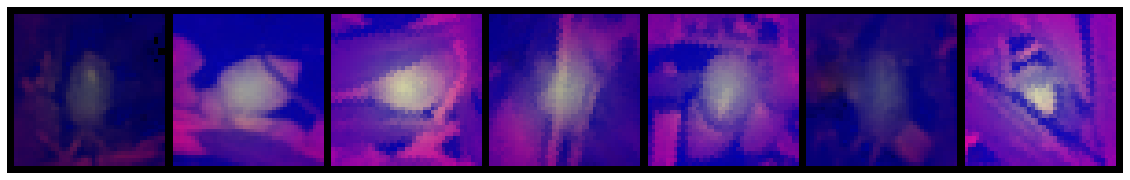

In [8]:
# Creamos los objetos datasets a partir de un ImageFolder de torchvision:
data_train = ImageFolder(datadir,transform=transforms.ToTensor())
train_loader = DataLoader(data_train, batch_size=10, shuffle=True, pin_memory=True)

# Mostramos el batch de entrenamiento:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,5))
plt.imshow(make_grid(images[labels==0,:]).permute(1, 2, 0)) # permute -> Matplotlib espera el canal en la última dimensión
plt.axis('off')

# **No Aceituna**

In [10]:
labels

tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 0])

(-0.5, 216.5, 44.5, -0.5)

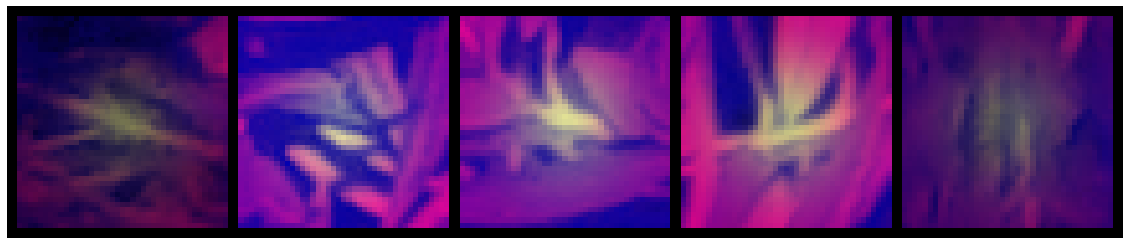

In [11]:
# Mostramos el batch de entrenamiento:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,5))
plt.imshow(make_grid(images[labels==1,:]).permute(1, 2, 0))
plt.axis('off')

### Carga de la imágenes
Cargamos las imágenes en un objeto *Dataset* mediante la función *ImageFolder*
*ImageFolder* es una función de la librería *torchvision* que facilita la carga de conjuntos de imágenes, etiquetándolas automáticamente según el subdirectorio donde las encuentre. Es decir, *ImageFolder* espera encontrar una estructura de directorios:

In [12]:
dataset = ImageFolder(root=datadir,transform=transforms.ToTensor())

Vemos que utilizamos el parámetro *transform*. Este parámetro se puede utilizar para que la función *ImageFolder* realice alguna transformación sobre las imágenes antes de almacenarlas en el objeto dataset. Si no se indica nada, por defecto *ImageFolder* genera un objeto PIL (Python Imaging Library) para cada imagen. En nuestro caso, utilizamos *ToTensor()* para que nos devuelva un tensor de tamaño 3x41x41 para cada imagen (41x41 pixeles, 3 canales de color). 

Extraemos una muestra del dataset y su etiqueta

In [13]:
x,y=dataset[0]
x.shape                    # Comprobamos su tamaño 

torch.Size([3, 41, 41])

Instanciamos el modelo y lo pasamos a la memoria de la GPU

In [14]:
model=MLP1(3*41*41).to('cuda')

Definimos la función de loss. En este caso utilizaremos *Cross Entropy Loss*. Como todas las funciones de pérdida, el objetivo es medir la distancia de la predicción realizada por un modelo con respecto a las etiquetas o *ground truth*. Esta función de loss, está relacionada con el concepto de entropía  dentro de la teoría de la información. La entropía es una medida del nivel de incertidumbre en los valores de salida del modelo. Es también una medida de la cantidad de información que contiene una variable aleatoria.
Se define como:
$$ L_{CE}=-\sum_{i=1}^{n}t_{i}log(p_{i}) $$

donde $t_i$ es la etiqueta y $p_i$ es la probabilidad correspondiente a la clase $i$ 

In [15]:
criterion = nn.CrossEntropyLoss()

Utilizamos descenso de gradiente estocástico con un learning-rate (factor que cuantifica cuánto vamos a actualizar los pesos con respecto
a su valor actual) de 0.01 y un momento de 0.9, que actualiza el learning rate en función de sus valores anteriores

In [16]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Simplemente vamos a utilizar una imagen y su etiqueta para mostrar el proceso de entrenamiento

In [17]:
# Datos de ejemplo:
images=x
labels=torch.Tensor([y]).type(torch.long)

Una iteración sería:

In [18]:
optimizer.zero_grad()                         # Ponemos a cero todos los gradientes en todas las neuronas
images=images.view(-1,3*41*41)                # Cambiamos el tamaño de la entrada y le cambio la forma
outputs = model(images.to('cuda'))            # Propagación hacia delante (Feed Forward) 
loss = criterion(outputs, labels.to('cuda'))  # Estimamos el loss (error)
loss.backward()                               # Propagación hacia atrás (backprop)
optimizer.step()                              # Optimización de los pesos

Con el código anterior, hemos presentado a la red una muestra, y hemos actualizado los (inicialmente aleatorios) en base al error (loss) correspondiente

Ahora, vemos cual sería la predicción que haría la red:

In [19]:
_, predicted = torch.max(outputs, 1) 

In [20]:
predicted.item()

0

## Código completo, utilizando un dataloader

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
datadir="/content/data/OLIVEnet/Subimagenes entrenamiento"

# Definición de la clase MLP
class MLP1(nn.Module):
    def __init__(self,input_neurons=41*41*3):
        super(MLP1, self).__init__()
        self.input_neurons=input_neurons                    # Entrada
        self.fc1 = nn.Linear(self.input_neurons, 1024)      # Pesos Entrada - Oculta 
        self.fc2 = nn.Linear(1024, 2)                       # Pesos Oculta - Salida
        
    def forward(self, x):
        x = x.view(-1, self.input_neurons)#transforma las imágenes de tamaño (n, 41*41*3) a (n, 41*41*3)
        x = F.relu(self.fc1(x))#Función de activación relu en la salida de la capa oculta
        x = F.softmax(self.fc2(x), dim=1)#Función de activación softmax en la salida
        return x
    
# Carga dataset y transforma objetos PIL que devuelve Image Folder a Tensores (PyTorch)
dataset = ImageFolder(root=datadir,transform=transforms.ToTensor())
# Generamos un subset aleatorio para que el entrenamiento sea más rápido en este ejercicio
train_idx=np.random.randint(0,len(dataset)-1,10000)
dataset_train = torch.utils.data.Subset(dataset, train_idx)
# Y definimos el dataloader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=500, shuffle=True)

# Genera modelo
model=MLP1(3*41*41).to('cuda')
# Define función de loss
criterion = nn.CrossEntropyLoss() # definimos la pérdida

# Utilizamos descenso de gradiente estocástico con un learning-rate 
# (factor que cuantifica cuánto vamos a actualizar los pesos con respecto
# a su valor actual) de 0.01 y un momento de 0.9, que actualiza el learning
# rate en función de sus valores anteriores
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 100 iteraciones de entrenamiento
loss_history=[]
for epoch in range(100):
    train_loss=0
    train_acc=0
    total_train=0
    for i, (images, labels) in enumerate(train_loader, 0):
        total_train+= labels.shape[0]
        optimizer.zero_grad()              # ponemos a cero todos los gradientes en todas las neuronas    
        images=images.view(-1,3*41*41)
        outputs = model(images.to('cuda'))            # Propagación hacia delante (Feed Forward) 
        loss = criterion(outputs, labels.to('cuda'))  # Estimamos el loss (error)
        train_loss+=loss.item()
        loss.backward()                               # Propagación hacia atrás (backprop)
        optimizer.step()                              # Optimización de los pesos
    loss_history.append(loss.item()/total_train)
    print('Step:', epoch, ' Loss:', train_loss/total_train)

Step: 0  Loss: 0.0013639978229999543
Step: 1  Loss: 0.001322775238752365
Step: 2  Loss: 0.0013039259314537048
Step: 3  Loss: 0.0012827013969421387
Step: 4  Loss: 0.0012688157081604003
Step: 5  Loss: 0.0012557138025760652
Step: 6  Loss: 0.001251631861925125
Step: 7  Loss: 0.0012454931616783143
Step: 8  Loss: 0.0012379571259021759
Step: 9  Loss: 0.0012411055505275727
Step: 10  Loss: 0.0012207538485527038
Step: 11  Loss: 0.001212770289182663
Step: 12  Loss: 0.0012061494648456573
Step: 13  Loss: 0.001201801037788391
Step: 14  Loss: 0.0012017045080661773
Step: 15  Loss: 0.0011970673978328704
Step: 16  Loss: 0.0011871155619621277
Step: 17  Loss: 0.0011846717953681947
Step: 18  Loss: 0.0011760954856872559
Step: 19  Loss: 0.0011716777682304383
Step: 20  Loss: 0.0011662597060203552
Step: 21  Loss: 0.0011790693998336792
Step: 22  Loss: 0.0011647158801555634
Step: 23  Loss: 0.001157119733095169
Step: 24  Loss: 0.001145131468772888
Step: 25  Loss: 0.00113884254693985
Step: 26  Loss: 0.001134673577

Mostramos la curva de loss

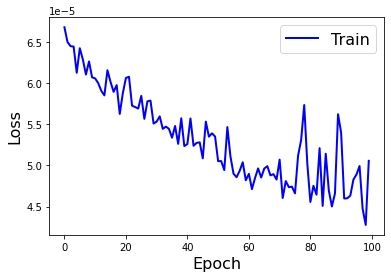

In [22]:
f, ax = plt.subplots()
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.plot(np.arange(len(loss_history)), loss_history, 'b-', lw=2,label='Train')
ax.legend(loc='upper right', fontsize=16)

## 2.2 Red MLP con dos capas. Procedimientos de entrenamiento/validación y Test

En esta parte, vamos a definir una arquitectura MLP con dos capas ocultas:

![Arquitectura MLP básico](material_notebook_Sesion1/MLP_imagenes2.png)

Además, utilizaremos el procedimiento de entrenamiento/validación para generar la curva de aprendizaje y finalmente, evaluaremos la red con el dataset de test. Utilizaremos este resultado para calcular las métricas de rendimiento del proceso de clasificación descritas en la teoría:
- Accuracy
- Sensibilidad
- Especificidad
- Curca ROC y AUC

** Más adelante en el curso, veremos métodos de validación de modelos! (Validación cruzada, remuestreo...) 

El código quedaría:

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.datasets import ImageFolder
from sklearn.model_selection import KFold,StratifiedKFold
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np
datadir="/content/data/OLIVEnet/Subimagenes entrenamiento"

# Definimos el modelo

class MLP2(nn.Module):
    def __init__(self,input_neurons=41*41):
        super(MLP2, self).__init__()
        self.input_neurons=input_neurons
        self.fc1 = nn.Linear(self.input_neurons, 512)      # Pesos Entrada - Oculta 1
        self.fc2 = nn.Linear(512, 1024 )                   # Pesos Oculta 1 - Oculta 2
        self.fc3 = nn.Linear(1024, 2)                      # Pesos Oculta 2 - Salida
        
    def forward(self, x):
        x = x.view(-1, self.input_neurons)                 #transforma las imágenes de tamaño (41x41x3) a (n, 41x41x3)
        x = F.relu(self.fc1(x))                            #Función de activación relu en la salida de la capa oculta 1
        x = F.relu(self.fc2(x))                            #Función de activación relu en la salida de la capa oculta 2
        x = F.softmax(self.fc3(x), dim=1)                  #Función de activación softmax en la salida
        return x

# Carga dataset y transforma objetos PIL que devuelve Image Folder a Tensores (PyTorch)
dataset = ImageFolder(root=datadir,transform=transforms.ToTensor())
# Genera modelo
model=MLP2(3*41*41).to('cuda')
# Define función de loss
criterion = nn.CrossEntropyLoss() # definimos la pérdida

# Utilizamos descenso de gradiente estocástico con un learning-rate 
# (factor que cuantifica cuánto vamos a actualizar los pesos con respecto
# a su valor actual) de 0.01 y un momento de 0.9, que actualiza el learning
# rate en función de sus valores anteriores
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Definimos el objeto que genera los índices para hacer validación cruzada 
#skf1 = KFold(shuffle=True)
#skf2 = StratifiedKFold(n_splits=5)
skf3 = StratifiedShuffleSplit(n_splits=1, train_size=0.1, test_size=0.05)

**OJO! No estamos haciendo validación cruzada, dado que los datasets de entrenamiento y test son diferentes y se nos dan por separado.
Utilizamos la función *StratifiedShuffleSplit* para generar subconjuntos de entrenamiento/validación y mostrar ambos *loss* durante el entrenamiento.

In [ ]:
# Bucle sobre los subconjuntos generados. Este código en general, podría utilizarse para k>1
n_epochs = 30   # 30 iteraciones en el entrenamiento
for i_fold, (train_idx, val_idx) in enumerate(skf3.split(dataset,dataset.targets)):
    # Datasets de train y test
    dataset_train = torch.utils.data.Subset(dataset, train_idx)
    dataset_validation = torch.utils.data.Subset(dataset, val_idx)
    
    # Creamos los dataloaders de train y test
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=500, shuffle=False, pin_memory=True)
    validation_loader = torch.utils.data.DataLoader(dataset_validation, batch_size=500, shuffle=False, pin_memory=True)
    train_history=[]
    val_history=[]
    # Iteramos para actualizar los pesos: entrenamiento
    for epoch in range(n_epochs):
        train_loss = 0.0    # el loss en cada epoch de entrenamiento
        train_acc = 0.0     # el accuracy de cada epoch
        val_loss = 0.0      # el loss en cada epoch de validación
        val_acc = 0.0       # el accuracy de cada epoch de validación
        total_train=0
        total_val=0

    
        # Iteramos con el trainloader
        for i, (images, labels) in enumerate(train_loader, 0):
            total_train += labels.shape[0]
            labels=labels.to('cuda')
            optimizer.zero_grad()                         # ponemos a cero todos los gradientes en todas las neuronas
    
            images=images.view(-1,3*41*41)
            outputs = model(images.to('cuda'))            # Propagación hacia delante (Feed Forward) 
            loss = criterion(outputs, labels)             # Estimamos el loss (error)
            loss.backward()                               # Propagación hacia atrás (backprop)
            optimizer.step()                              # Optimización de los pesos
            
            # Mostramos las estadísticas conforme entrenamos la red
            train_loss += loss.item() # acumulamos el loss de este batch
            # extraemos las etiquetas que predice (nº neurona con máxima probabilidad)
            _, predicted = torch.max(outputs, 1) 
            train_acc += torch.sum(predicted==labels) # y acumulamos el número de correctos
        
        train_history.append(train_loss/total_train)
        
        # Ahora vamos con el bucle de validación para evaluar el modelo 
        for j, (images,labels) in enumerate(validation_loader,0):
            total_val+= labels.shape[0]
            labels=labels.to('cuda')
            images=images.view(-1,3*41*41)
            outputs = model(images.to('cuda'))     
            loss = criterion(outputs, labels)  # Estimamos el loss (error)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1) 
            val_acc += torch.sum(predicted==labels)
            
        val_history.append(val_loss/total_val)
        print(f'>>> Epoch {epoch} >>>> Train Loss: {train_loss/total_train}, Train Acc: {train_acc/total_train}, Val Loss: {val_loss/total_val}, Val Acc: {val_acc/total_val}')

>>> Epoch 0 >>>> Train Loss: 0.0013631755555494679, Train Acc: 0.5599590539932251, Val Loss: 0.0013604283699340585, Val Acc: 0.6320778727531433
>>> Epoch 1 >>>> Train Loss: 0.0013086749530302855, Train Acc: 0.635292112827301, Val Loss: 0.0013114911290845676, Val Acc: 0.6512938737869263
>>> Epoch 2 >>>> Train Loss: 0.0012714184711196945, Train Acc: 0.6576700210571289, Val Loss: 0.0012806881369000181, Val Acc: 0.6676061153411865
>>> Epoch 3 >>>> Train Loss: 0.001245822219116353, Train Acc: 0.6734711527824402, Val Loss: 0.0012510327364747026, Val Acc: 0.6874199509620667
>>> Epoch 4 >>>> Train Loss: 0.001227007143461627, Train Acc: 0.6846600770950317, Val Loss: 0.001242437766041985, Val Acc: 0.690579891204834
>>> Epoch 5 >>>> Train Loss: 0.0012143894159472107, Train Acc: 0.6889733672142029, Val Loss: 0.0012363732212358886, Val Acc: 0.6951917409896851
>>> Epoch 6 >>>> Train Loss: 0.00120575520867653, Train Acc: 0.6938418745994568, Val Loss: 0.0012286527271467857, Val Acc: 0.6998035907745361

Definimos algunas funciones auxiliares para mostrar las estadísticas de clasificación y la curva de aprendizaje

In [ ]:
######################################################################################################################
# Funciones auxiliares. 
#       Calculo de estadísticas
#       Curva de aprendizaje
######################################################################################################################
from sklearn.metrics import confusion_matrix, roc_curve, auc


def clasif_perf(predicted,actual):
    # Cálculo de estadísticas y métricas de clasificación
    cm = confusion_matrix(actual,predicted)
    # from confusion matrix calculate acc, sens, spec
    total=sum(sum(cm))
    acc=(cm[0,0]+cm[1,1])/total
    sens = cm[0,0]/(cm[0,0]+cm[0,1])
    spec = cm[1,1]/(cm[1,0]+cm[1,1])
    return acc,sens,spec 

def plot_learning_curve(train_history,validation_history):
    # Plot Learning Curve
    fig=plt.figure()
    plt.plot(np.arange(len(train_history)),train_history,'b-',label='Training')
    plt.plot(np.arange(len(val_history)),val_history,'r-',label='Validation')
    plt.legend(loc='upper right',fontsize=14)
    plt.xlabel("epoch",fontsize=14)
    plt.ylabel("Loss",fontsize=14)

Mostramos la curva de aprendizaje

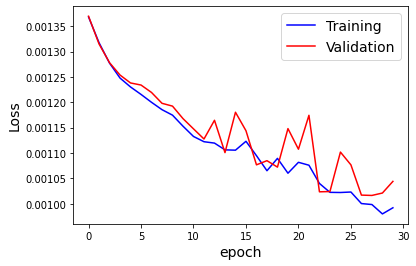

In [ ]:
plot_learning_curve(train_history,val_history)

In [ ]:
train_history

[0.0013682371674237253,
 0.001317530717709629,
 0.0012772396909404543,
 0.0012477628675425952,
 0.001230229462296799,
 0.0012155376071811008,
 0.0011999628188099354,
 0.0011854384655752075,
 0.0011746442975711204,
 0.0011528637813837568,
 0.0011326111407666064,
 0.0011222521711788693,
 0.0011195304412502944,
 0.001106225348675581,
 0.0011055678546652683,
 0.0011230879725756644,
 0.0010947369377605736,
 0.0010650570243138846,
 0.0010894139688353837,
 0.001060164818329578,
 0.0010816527598642186,
 0.0010759046407518918,
 0.001039979490029922,
 0.0010224270396033855,
 0.0010221167905036606,
 0.0010230681306272389,
 0.0010002946801201083,
 0.0009983748587011924,
 0.00097988785295752,
 0.0009920027426456404]

Una vez entrenado el modelo, estimamos su capacidad de generalización con el dataset de test.
Para poder calcular la curva ROC necesitamos un score y la etiqueta "ground truth". El score lo obtenemos restando los dos valores que proporciona softmax (la activación para cada neurona de salida).
Almacenamos estos scores en la variable *scores*, y guardamos las etiquetas "ground truth" en *lab_mat* así como las predicciones de la red en *pred_mat*

In [ ]:
dataset_test = ImageFolder(root='/content/data/OLIVEnet/Subimagenes validacion',transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=500, shuffle=False)
correct = 0
total = 0

with torch.no_grad():       # hay que deshabilitar la propagación de gradiente
    for i, (images, labels) in enumerate(test_loader,0):
        outputs = model(images.to('cuda'))                  # Propagación hacia delante
        _, predicted = torch.max(outputs, 1)                # obtención de etiquetas numéricas
        total += labels.size(0)                             # Incrementa el número de etiquetas comprobadas para calcular la precisión después
        correct += torch.sum(predicted == labels.to('cuda')).item() # sumamos el número de etiquetas correctas para calcular la precisión
        if i==0:
            pred_mat=predicted.detach().cpu().numpy()
            lab_mat=labels.detach().cpu().numpy()
            scores=np.diff(outputs.detach().cpu().numpy()).flatten()
        else:
            pred_mat=np.hstack((pred_mat,predicted.detach().cpu().numpy()))
            lab_mat=np.hstack((lab_mat,labels.detach().cpu().numpy()))
            scores=np.hstack((scores,np.diff(outputs.detach().cpu().numpy()).flatten()))


print(f'Precisión del modelo en las imágenes de test: {correct / total}')

Precisión del modelo en las imágenes de test: 0.6792622672080975


Calculamos las métricas

In [ ]:
### Calculo de estadísticas:
acc,sens,spec=clasif_perf(pred_mat,lab_mat)
print('Accuracy: %1.3f, Sensibilidad: %1.3f, Especificidad: %1.3f' %(acc,sens,spec))

Accuracy: 0.679, Sensibilidad: 0.938, Especificidad: 0.664


## 2.3 Clasificación multiclase

Hasta ahora, hemos realizado ejemplos de clasificación binaria con una red MLP. Sin embargo, es posible utilizar la misma red para realizar una clasificación multiclase. La base de datos que estamos utilizando sólo tiene dos clases (aceituna=0 / no aceituna=1). Por ello, vamos a utilizar una nueva base de datos para este ejemplo.
En este caso, utilizaremos la base de datos denominada "variedades", que contiene imágenes de hasta 7 variedaddes distintas de aceituna. El objetivo será entrenar nuestra red para diferenciar entre clases.
Veamos un ejemplo de las imágenes con las que vamos a trabajar

Estas iḿagenes son de 501x501 pixeles y también contienen 3 canales

In [ ]:
#@title Desarga y descompresión de datos
data_id = "variedades" #@param ["variedades", "olivenet"]

correspond = {'variedades': '16vvJkbZPHTyBeB7bo6UUs3aveeK_9TuY', 
              'olivenet': '1-LFuqLydW7zwEFbaci54SJKTWzNIr9OU'}
if data_id=='variedades':
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=16vvJkbZPHTyBeB7bo6UUs3aveeK_9TuY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=16vvJkbZPHTyBeB7bo6UUs3aveeK_9TuY" -O 'variedades.zip' && rm -rf /tmp/cookies.txt
elif data_id=='olivenet':
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-LFuqLydW7zwEFbaci54SJKTWzNIr9OU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-LFuqLydW7zwEFbaci54SJKTWzNIr9OU" -O 'olivenet.zip' && rm -rf /tmp/cookies.txt
else:
  print('wrong id')
!mkdir data
!unzip {data_id}.zip -d data

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: data/Variedades/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0038_1.TIFF  
  inflating: data/Variedades/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0038_2.TIFF  
  inflating: data/Variedades/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0038_3.TIFF  
  inflating: data/Variedades/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0038_4.TIFF  
  inflating: data/Variedades/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0038_5.TIFF  
  inflating: data/Variedades/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0038_6.TIFF  
  inflating: data/Variedades/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0038_7.TIFF  
  inflating: data/Variedades/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0041_2.TIFF  
  inflating: data/Variedades/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0041_3.TIFF  
  inflating: data/Variedades/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0041_5.TIFF  
  inflating: data/Variedades/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0041_6.

Las clases, las codificaremos así:

    Arbequina = 0
    Arbosana  = 1
    Changlot  = 2
    Lechín    = 3
    Ocal      = 4
    Picual    = 5
    Verdial   = 6
    
que es la codificación por defecto que asigna ImageFolder
    
    

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
datadir="/content/data/Variedades/ENTRENAMIENTO_45_GREYSCALE"

In [ ]:
dataset = ImageFolder(root=datadir,transform=transforms.ToTensor())
train_loader = DataLoader(dataset, batch_size=100, shuffle=True, pin_memory=True)
images,labels=next(iter(train_loader))


In [ ]:
dataset.class_to_idx

{'Arbequina': 0,
 'Arbosana': 1,
 'Changlot': 2,
 'Lechin': 3,
 'Ocal': 4,
 'Picual': 5,
 'Verdial': 6}

**Vemos imágenes de ejemplo para cada clase**

(-0.5, 500.5, 500.5, -0.5)

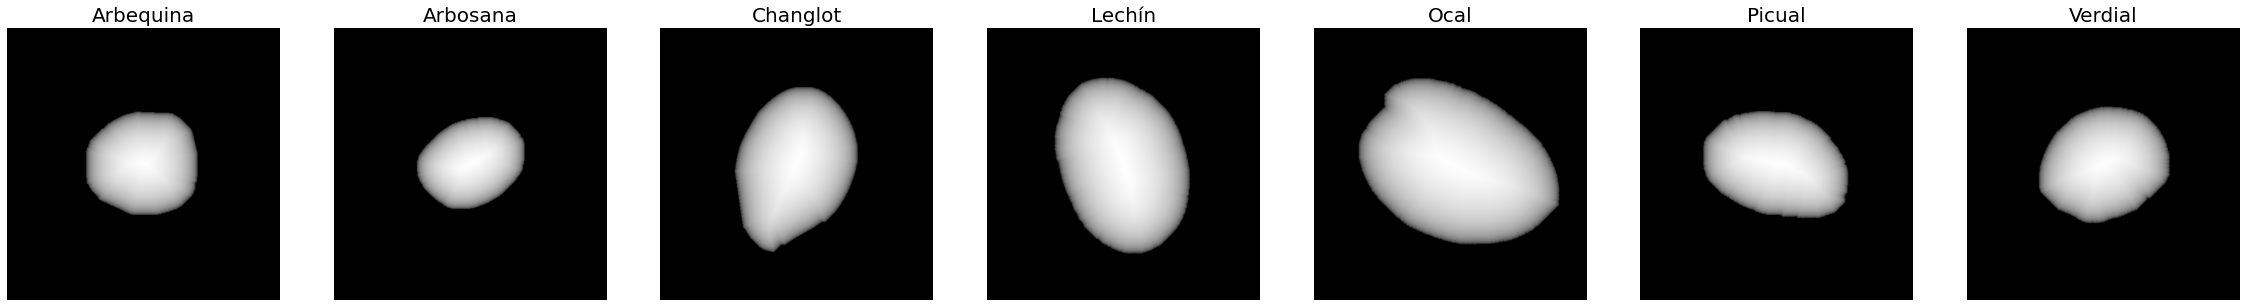

In [ ]:
im0=images[labels==0,:]
im1=images[labels==1,:]
im2=images[labels==2,:]
im3=images[labels==3,:]
im4=images[labels==4,:]
im5=images[labels==5,:]
im6=images[labels==6,:]
fig=plt.figure(figsize=(40,10))
plt.subplot(1,7,1); plt.imshow(im0[0,:].permute(1,2,0)); plt.title("Arbequina",fontsize=20); plt.axis('off')
plt.subplot(1,7,2); plt.imshow(im1[0,:].permute(1,2,0)); plt.title("Arbosana",fontsize=20); plt.axis('off')
plt.subplot(1,7,3); plt.imshow(im2[0,:].permute(1,2,0)); plt.title("Changlot",fontsize=20); plt.axis('off')
plt.subplot(1,7,4); plt.imshow(im3[0,:].permute(1,2,0)); plt.title("Lechín",fontsize=20); plt.axis('off')
plt.subplot(1,7,5); plt.imshow(im4[0,:].permute(1,2,0)); plt.title("Ocal",fontsize=20); plt.axis('off')
plt.subplot(1,7,6); plt.imshow(im5[0,:].permute(1,2,0)); plt.title("Picual",fontsize=20); plt.axis('off')
plt.subplot(1,7,7); plt.imshow(im6[0,:].permute(1,2,0)); plt.title("Verdial",fontsize=20); plt.axis('off')






In [ ]:
Ahora, modificamos la clase MLP para que a la salida tenga 7 neuronas y la llamamos MLP3:
    
class MLP3(nn.Module):
    def __init__(self,input_neurons=41*41*3):
        super(MLP3, self).__init__()
        self.input_neurons=input_neurons
        self.fc1 = nn.Linear(self.input_neurons, 512) # 
        self.fc2 = nn.Linear(512, 1024 ) # 
        self.fc3 = nn.Linear(1024, 7) #   7 clases! 
        
    def forward(self, x):
        x = x.view(-1, self.input_neurons)#transforma las imágenes de tamaño (n, 28, 28) a (n, 784)
        x = F.relu(self.fc1(x))#Función de activación relu en la salida de la capa oculta
        x = F.relu(self.fc2(x))#Función de activación relu en la salida de la capa oculta
        x = F.softmax(self.fc3(x), dim=1)#Función de activación softmax en la salida de la capa oculta
        return x

## Ejercicio: Modificar el programa completo para entrenamiento, validación y test con 7 clases